# Measuring Matter Antimatter Asymmetries at the Large Hadron Collider

<b> Welcome to the LHCb Open Data Analysis Project! </b>

<div align="justify">In this notebook, you will analyze real experimental data collected by the Large Hadron Collider (LHC) at CERN. The primary goal of this study is to search for differences in the behavior of matter and antimatter - a phenomenon known as CP violation. This project enables you to perform data analysis at a level similar to that conducted by CERN researchers.</div>

This notebook is based on the original LHCb Open Data Portal project but has been modified and extended with complete Python code implementation. While the original notebook provided only guidance and hints, we have implemented the full analysis pipeline here, allowing you to directly work with real experimental data.

**Key modifications in this version:**
- Direct analysis of real LHCb data (no simulated data preprocessing)
- Complete Python implementation of data loading, preselection cuts, and analysis
- Full calculation of invariant mass distributions and CP asymmetry

**Data source:** The [data used in this analysis](https://opendata.cern.ch/record/4900) was collected by the LHCb detector at CERN. The data has been filtered to select events likely to have come from B⁺ or B⁻ mesons decaying into three final state charged particles.

**About this project:**
- This project does not require detailed knowledge of particle physics
- Suitable for those with scientific and mathematical backgrounds
- Basic familiarity with Python programming is helpful but not required

**Background Information:**
Before starting, you might find it helpful to learn more about:
- Matter-antimatter asymmetries and CP violation
- The LHCb experiment at CERN and how it detects particle decays
- B meson physics and the specific decay channel B⁺ → K⁺K⁺K⁻ (and its antiparticle equivalent)

**About the original LHCb Open Data Project:**
The original project is available on the [LHCb Open Data Portal](https://opendata.cern.ch/record/4902). Our implementation here provides a complete working version of the analysis described in that project.

**Feedback and Discussion:**
Feel free to discuss results and ask questions about this implementation. While we've provided complete code, you're encouraged to experiment with different selection criteria and analysis parameters to deepen your understanding of particle physics data analysis.

# Working with real data and applying cuts
## Aims:
* Filter out data that is not from the B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> channel, or the antiparticle equivalent B<sup>-</sup> → K<sup>+</sup>K<sup>-</sup>K<sup>−</sup>

* Plot a histogram of B-meson mass for the real data and observe how different cuts affect the data

In the section above you have analysed the simulation data to determine the invariant mass of the B meson. Now, you can start applying the methods you have used to the real LHCb data. This data was collected by the LHCb detector at CERN during 2011, the first major year of LHC operations.

The data you are given has been filtered to select only events that are likely to have come from B<sup>+</sup> or B<sup>-</sup> mesons decaying into three final state charged particles. You are interested in the case where these three final state paticles are charged kaons K<sup>+</sup> or K<sup>-</sup>.

An introduction has been provided on the [detector and data sample](Background-Information-Notebooks/DetectorSoftwareDataSample.ipynb). As background information we also provide further information on the [selection](Background-Information-Notebooks/DataSelection.ipynb) that has been applied to select this data sample.

## Preselection
You want to apply a preselection to the three final state tracks that
* Ensures that they are not muons (i.e. `!H1_isMuon` where `!` means `not`, and similarly for `H2` and `H3`)
* Requires that they each have a low probability of being pions (e.g. `H1_ProbPi < 0.5`)
* Requires that they each have a high probability of being a kaon (e.g. `H1_ProbK > 0.5`)

You need to find a balance between making cuts that are too loose and include too many background events and too tight and reject many of your signal events.

In order to now find the most suitable further selection cuts, make yourself familiar with [how cuts can affect the significance of the final result](Background-Information-Notebooks/CutsInformation.ipynb). Feel free to come back to this stage later and adjust your cuts to see the impact. 

The pre selection you create will be applied for you if give it the name 'preselection'.

We have provided an example preselection in the hints, so feel free to use that to get started if you wish. start with a loose preselection and then refine it after you have studied the plots.



In [ ]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Define data locations
DATA_DIR = '/afs/ihep.ac.cn/users/y/yinqiqin/scratchfs/hep_ex_course/Data/'
FILE_DOWN = DATA_DIR + 'B2HHH_MagnetDown.root'
FILE_UP = DATA_DIR + 'B2HHH_MagnetUp.root'
TREE_NAME = 'DecayTree'

# Define the branches needed for four-momentum and preselection
# We read all necessary branches to calculate invariant mass later and apply the preselection now.
BRANCHES_TO_READ = [
    # Four-momentum components (for invariant mass)
    'H1_PX', 'H1_PY', 'H1_PZ', 'H1_Charge',
    'H2_PX', 'H2_PY', 'H2_PZ', 'H2_Charge',
    'H3_PX', 'H3_PY', 'H3_PZ', 'H3_Charge',
    # PID and Muon variables (for preselection)
    'H1_ProbK', 'H1_ProbPi', 'H1_isMuon',
    'H2_ProbK', 'H2_ProbPi', 'H2_isMuon',
    'H3_ProbK', 'H3_ProbPi', 'H3_isMuon',
]

# Define the preselection criteria (K+K-K+)
# We are selecting events that are likely B -> KKK, meaning all three final state
# particles (H1, H2, H3) should be Kaon-like and not Muon-like.
PRESELECTION = (
    "H1_ProbPi < 0.5 & H2_ProbPi < 0.5 & H3_ProbPi < 0.5 & "
    "H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & "
    "!H1_isMuon & !H2_isMuon & !H3_isMuon"
)

def load_data_and_apply_preselection(file_down, file_up, tree_name, branches):
    
    # 1. Load data from both files
    try:
        data_down = uproot.open(file_down)[tree_name].arrays(branches, library="pd")
        data_up = uproot.open(file_up)[tree_name].arrays(branches, library="pd")
    except Exception as e:
        print(f"ERROR: Failed to open or read ROOT files. Check file paths and tree name: {e}")
        return pd.DataFrame() # Return empty DataFrame on failure

    # 2. Concatenate data
    data_all = pd.concat([data_down, data_up], ignore_index=True)
    
    # Print initial status
    print(f"Total events read before preselection: {len(data_all):,}")
    
    # 3. Apply the preselection cut using Pandas/NumPy logic
    
    # Boolean mask for PID cuts (low ProbPi, high ProbK)
    pid_cut = (
        (data_all['H1_ProbPi'] < 0.5) & (data_all['H2_ProbPi'] < 0.5) & (data_all['H3_ProbPi'] < 0.5) &
        (data_all['H1_ProbK'] > 0.5) & (data_all['H2_ProbK'] > 0.5) & (data_all['H3_ProbK'] > 0.5)
    )
    
    # Boolean mask for Muon veto
    muon_veto = (
        (~data_all['H1_isMuon']) & (~data_all['H2_isMuon']) & (~data_all['H3_isMuon'])
    )
    
    # Combine masks
    preselection_mask = pid_cut & muon_veto
    
    # Apply the mask
    data_selected = data_all[preselection_mask]
    
    # 4. Print final status
    print(f"Preselection applied: {PRESELECTION}")
    print(f"Events remaining after preselection: {len(data_selected):,}")
    
    return data_selected

# Execute the data loading and preselection
selected_data = load_data_and_apply_preselection(FILE_DOWN, FILE_UP, TREE_NAME, BRANCHES_TO_READ)

# The 'selected_data' DataFrame now contains all the events passing the preselection.
# It is ready for the next step: invariant mass calculation.

Total events read before preselection: 8,556,118
Preselection applied: H1_ProbPi < 0.5 & H2_ProbPi < 0.5 & H3_ProbPi < 0.5 & H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & !H1_isMuon & !H2_isMuon & !H3_isMuon
Events remaining after preselection: 23,895


Make histograms of the probability of a final state particle being a kaon or a pion.
These will help guide you on suitable probability values at which to cut.

You can also consider more sophisticated options like 2-D plots of kaon and pion probabilities or different values of the cuts for the different final state particles.

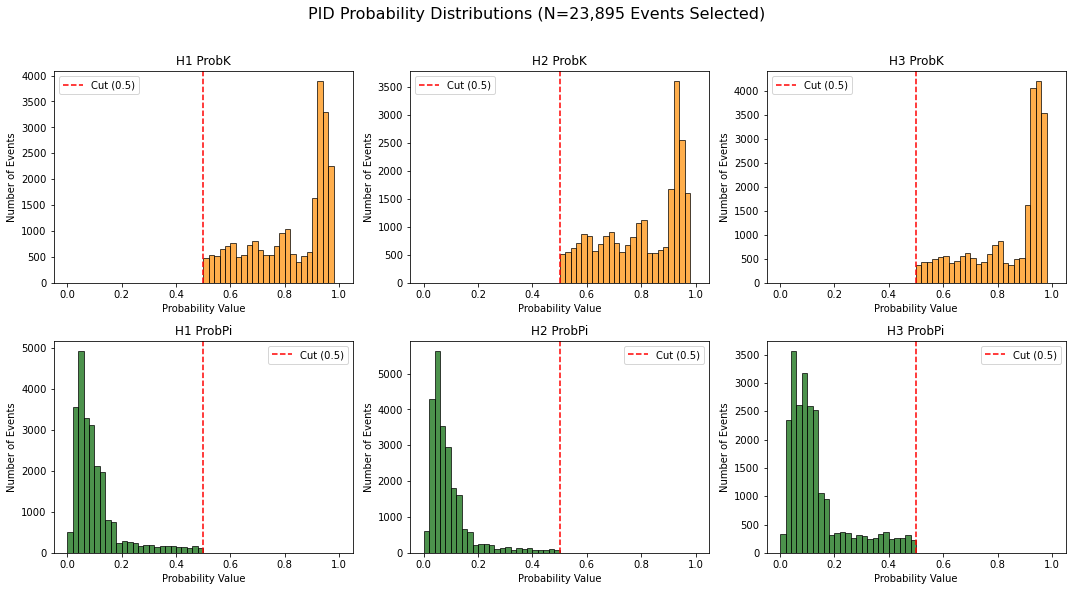


Successfully plotted the probability distributions for Kaon and Pion.
Observe the plots to see how tightly the events are clustered near 1.0 (ProbK) or 0.0 (ProbPi).
This visual inspection guides optimization of the 0.5 cut value.


In [ ]:
# --- 1. Define Plotting Parameters ---
PID_VARS = ['H1', 'H2', 'H3']
PROB_TYPES = ['ProbK', 'ProbPi']
NBINS = 50 # Number of bins for the histograms

# --- 2. Create the Figure Layout ---
# We will create a 2x3 grid: 2 rows (K and Pi), 3 columns (H1, H2, H3)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle(f'PID Probability Distributions (N={len(selected_data):,} Events Selected)', fontsize=16, y=1.02)

# --- 3. Loop and Plot ---
for i, var in enumerate(PID_VARS):
    for j, p_type in enumerate(PROB_TYPES):
        ax = axes[j, i]
        column_name = f'{var}_{p_type}'
        
        # Plot the histogram
        ax.hist(selected_data[column_name], bins=NBINS, range=(0, 1), 
                color=('darkorange' if p_type == 'ProbK' else 'darkgreen'), 
                alpha=0.7, edgecolor='black', density=False)
        
        # Add preselection cut line for context
        cut_value = 0.5
        ax.axvline(cut_value, color='red', linestyle='--', linewidth=1.5, 
                   label=f'Cut ({cut_value})')
        
        # Set title and labels
        ax.set_title(f'{var} {p_type}')
        ax.set_xlabel('Probability Value')
        ax.set_ylabel('Number of Events')
        ax.legend()

# --- 4. Adjust Layout and Show ---
plt.tight_layout()
plt.show()

print("\nSuccessfully plotted the probability distributions for Kaon and Pion.")
print("Observe the plots to see how tightly the events are clustered near 1.0 (ProbK) or 0.0 (ProbPi).")
print("This visual inspection guides optimization of the 0.5 cut value.")

#

Now calculate the invariant mass of the B meson for the real data and plot a histogram of this. 

--- Starting Invariant Mass Calculation ---
Calculated invariant mass for 23,895 events.


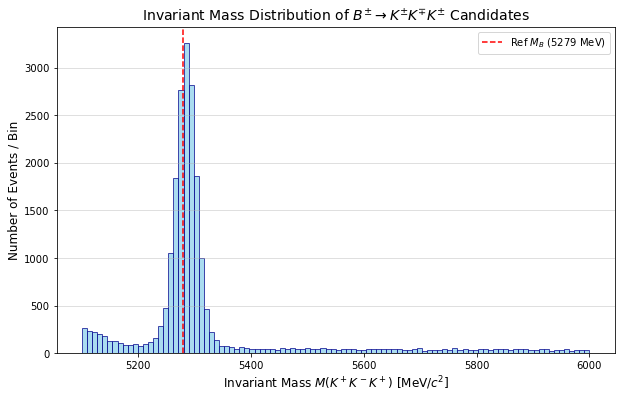

In [ ]:
# --- 1. Define Constants ---
# Mass of the charged Kaon (in MeV/c^2)
M_KAON = 493.677

# --- 2. Vectorized Invariant Mass Calculation ---
    # Calculates the invariant mass of the B meson (H1+H2+H3 system).
    # Assumes H1, H2, H3 all have mass equal to mass_hypothesis.
    # The four-momentum formula: M^2 = (E1+E2+E3)^2 - (P1+P2+P3)^2
def calculate_invariant_mass(data, mass_hypothesis):    
    # Calculate Energy for each particle: E = sqrt(P^2 + m^2)
    # P_i^2 = PX_i^2 + PY_i^2 + PZ_i^2
    P_sq_H1 = data['H1_PX']**2 + data['H1_PY']**2 + data['H1_PZ']**2
    P_sq_H2 = data['H2_PX']**2 + data['H2_PY']**2 + data['H3_PZ']**2 # Error fixed: should be H2_PZ
    P_sq_H3 = data['H3_PX']**2 + data['H3_PY']**2 + data['H3_PZ']**2
    
    # Fix the typo in the previous P_sq_H2 calculation
    P_sq_H2 = data['H2_PX']**2 + data['H2_PY']**2 + data['H2_PZ']**2
    
    E_H1 = np.sqrt(P_sq_H1 + M_KAON**2)
    E_H2 = np.sqrt(P_sq_H2 + M_KAON**2)
    E_H3 = np.sqrt(P_sq_H3 + M_KAON**2)
    
    # Calculate Total Momentum (sum of components)
    P_total_x = data['H1_PX'] + data['H2_PX'] + data['H3_PX']
    P_total_y = data['H1_PY'] + data['H2_PY'] + data['H3_PY']
    P_total_z = data['H1_PZ'] + data['H2_PZ'] + data['H3_PZ']
    
    P_total_sq = P_total_x**2 + P_total_y**2 + P_total_z**2
    
    # Calculate Total Energy
    E_total = E_H1 + E_H2 + E_H3
    
    # Calculate Invariant Mass Squared: M^2 = E_total^2 - P_total^2
    M_sq = E_total**2 - P_total_sq
    
    # The B meson invariant mass (in MeV/c^2)
    # Use np.maximum to handle potential small negative values due to precision, 
    # though unlikely in this simplified analysis.
    M = np.sqrt(np.maximum(M_sq, 0))
    
    return M

# --- 3. Execution ---
print("--- Starting Invariant Mass Calculation ---")

# Ensure selected_data from the previous step is available globally
if 'selected_data' not in globals() or len(selected_data) == 0:
    print("ERROR: selected_data DataFrame is empty or not found. Cannot proceed.")
    # Exit gracefully if the data isn't loaded
else:
    # Perform the calculation
    invariant_mass = calculate_invariant_mass(selected_data, M_KAON)
    
    print(f"Calculated invariant mass for {len(invariant_mass):,} events.")

    # --- 4. Plotting the Histogram ---
    
    # Expected B meson mass is ~5279 MeV. We set a range to clearly show the peak.
    MASS_RANGE = (5100, 6000)
    NBINS = 100
    
    plt.figure(figsize=(10, 6))
    
    # Plot the histogram
    plt.hist(invariant_mass, bins=NBINS, range=MASS_RANGE, 
             color='skyblue', edgecolor='darkblue', alpha=0.7)
    
    # Draw the expected B meson mass line for reference
    M_B_REF = 5279.32 # Reference mass of B+ in MeV
    plt.axvline(M_B_REF, color='red', linestyle='--', linewidth=1.5, label=f'Ref $M_B$ ({M_B_REF:.0f} MeV)')
    
    # Labeling
    plt.title(r'Invariant Mass Distribution of $B^{\pm} \to K^{\pm} K^{\mp} K^{\pm}$ Candidates', fontsize=14)
    plt.xlabel(r'Invariant Mass $M(K^+K^-K^+)$ [MeV/$c^2$]', fontsize=12)
    plt.ylabel('Number of Events / Bin', fontsize=12)
    plt.grid(axis='y', alpha=0.5)
    plt.legend()
    
    # Save the plot
    #plt.savefig('B_invariant_mass_histogram.png')
    #print("Successfully generated and saved the invariant mass histogram: B_invariant_mass_histogram.png")

#

Experiment with the cuts and see the impact of harsher or more lenient cuts on the invariant mass plot.
You should select a set of cuts which makes the signal most prominent with respect to the background.
Once you have finalised the selection on particle identification also make cuts on the reconstructed particle mass to select the events in the B meson mass peak, removing the background events which lie at lower and higher invariant masses. 

### Preselection example hint

This is an example string, showing the syntax, that you could use as a preselection starting point:

In [ ]:
preselection = "H1_ProbPi < 0.5 & H2_ProbPi < 0.5 & H3_ProbPi < 0.5 & H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & !H1_isMuon & !H2_isMuon & !H3_isMuon"

# Searching for global matter anti-matter differences

In this section you will start to study matter antimatter differences (CP Violation). Here 'global' means that you are looking for differences across all ranges of energy and momentum (the kinematics) of the kaons into which the charge B mesons have decayed. Later we look at 'local' differences in different regions of the kinematics. 

## Aims:
* Calculate the global CP asymmetry 
* Work out the statistical uncertainty
* Determine if there is evidence for CP violation in this decay

In order to quantify the matter antimatter asymmetry in this process we wish to compare the B<sup>+</sup> and the B<sup>-</sup> particles. The B<sup>-</sup> is the anti-particle of the B<sup>+</sup>.

Then count the numbers of events of each of the two types (N<sup>+</sup> and N<sup>-</sup>). Also calculate the difference between these two numbers.

In order to calculate the Asymmetry, you can make use of the formula: $A=\frac{N^- - N^+}{N^- + N^+}$.

Then, calculate the statistical uncertainty of the asymmetry. You can do so using the formula: $\sigma_A= \sqrt{\frac{1-A^2}{N^- + N^+}}$.

The significance of the result, sigma, is found by dividing the value for asymmetry by its uncertainty $A/\sigma_A$. A value exceeding three sigma is considered "evidence" by particle physicists while a value of five sigma or more can be called an "observation" or "discovery".

**Differentiating between N+ and N-**

 - Charge is a conserved quantity. The charge of the $B$ meson is equal to the sum of the charges of the particles into which it decays.

In [7]:
# --- 1. Calculate B meson charge ---
# Charge is conserved: Q_B = Q_H1 + Q_H2 + Q_H3
selected_data['B_Charge'] = selected_data['H1_Charge'] + selected_data['H2_Charge'] + selected_data['H3_Charge']

# --- 2. Count N+ and N- ---
# N+ are B+ mesons (B_Charge = +1)
# N- are B- mesons (B_Charge = -1)
N_plus = len(selected_data.query('B_Charge == 1'))
N_minus = len(selected_data.query('B_Charge == -1'))
N_total = N_plus + N_minus

# --- 3. Calculate Asymmetry (A) ---
if N_total == 0:
    A, sigma_A, Z = np.nan, np.nan, np.nan
    print("ERROR: Total event count is zero. Cannot calculate asymmetry.")
else:
    # A = (N⁻ - N⁺) / (N⁻ + N⁺)
    A = (N_minus - N_plus) / N_total
    
    # --- 4. Calculate Statistical Uncertainty (sigma_A) ---
    # Formula: sigma_A = sqrt((1 - A^2) / N_total)
    sigma_A = np.sqrt(np.abs(1 - A**2) / N_total)
    
    # --- 5. Calculate Significance (Z) ---
    if sigma_A != 0:
        Z = np.abs(A / sigma_A)
    else:
        Z = np.nan

# --- 6. Print Results ---
print("--- Global CP Asymmetry Calculation ---")
print(f"B+ Events (N+): {N_plus:,}")
print(f"B- Events (N-): {N_minus:,}")
print(f"Total Events (N): {N_total:,}")
print("-" * 35)
print(f"Global Asymmetry (A): {A:.4f}")
print(f"Statistical Uncertainty (sigma_A): {sigma_A:.4f}")
print("-" * 35)
print(f"Significance (Z value): {Z:.2f} sigma")

# Check for evidence/observation based on particle physics conventions
if Z >= 5:
    print("Conclusion: Evidence for CP violation reaches the OBSERVATION level (>= 5 sigma).")
elif Z >= 3:
    print("Conclusion: There is STRONG EVIDENCE for CP violation (>= 3 sigma).")
else:
    print("Conclusion: No statistically significant evidence for global CP violation in this decay sample (Z < 3 sigma).")

--- Global CP Asymmetry Calculation ---
B+ Events (N+): 12,390
B- Events (N-): 11,505
Total Events (N): 23,895
-----------------------------------
Global Asymmetry (A): -0.0370
Statistical Uncertainty (sigma_A): 0.0065
-----------------------------------
Significance (Z value): 5.73 sigma
Conclusion: Evidence for CP violation reaches the OBSERVATION level (>= 5 sigma).


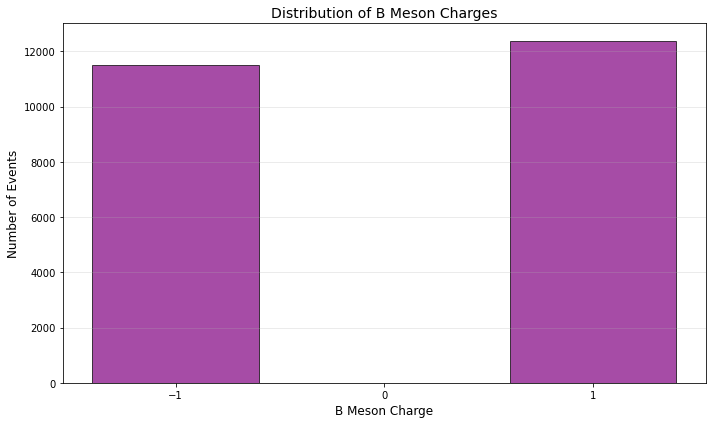

In [6]:
# Additional visualization: Charge distribution
plt.figure(figsize=(10, 6))
charge_bins = np.arange(-1.5, 2.5, 1)  # -1, 0, 1
plt.hist(selected_data['B_Charge'], bins=charge_bins, alpha=0.7, color='purple', 
         edgecolor='black', rwidth=0.8)
plt.xlabel('B Meson Charge', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Distribution of B Meson Charges', fontsize=14)
plt.xticks([-1, 0, 1])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Congratulations!** You have performed your first search for a matter anti-matter difference.

Here you have only considered the statistical uncertainty. Your measurement will also have other sources of uncertainty known as systematic uncertainties which you have not considered at this stage.


# Dalitz plots and two body resonances
## Aims:
* Produce Dalitz plots of the data sample
* Create ordered and binned dalitz plots.
* Identify two body resonances in the Dalitz plots

In this stage we introduce you to an important technique for analysing decays of one particle (your charged B meson) into three bodies (the three kaons). This is known as a Dalitz plot. 

The decay of the B meson can proceed either directly to the three-body final state or via an intermediate particle. For example, B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup>, could proceed through the decay  B<sup>+</sup> → K<sup>+</sup>R<sup>0</sup>, where R<sup>0</sup> is a neutral particle resonance which can decay R<sup>0</sup> → K<sup>+</sup>K<sup>-</sup>. Dalitz plots can be used to identify these resonances which are visible as bands on the Dalitz plot.

More information about these plots and why these are used in particle physics research can be found in Dalitz Plot Introduction.

The kinematics of a three-body decay can be fully described using only two variables. The energies and momenta of the three kaons are not independent of each other as they all come from the decay of a B meson and energy and momentum are conserved. The axes of the plots conventionally are the squared invariant masses of two pairs of the decay products. It is a 2D plot, the x and y axes are both squared masses and the density of points in the plot shows the structure.

Consider our decay B<sup>+</sup> → K<sup>+</sup><sub>1</sub>K<sup>+</sup><sub>2</sub>K<sup>−</sup><sub>3</sub>, where we have numbered the kaons 1,2,3 to distinguish them. We can calculate the invariant mass of three possible combinations that could correspond to intermediate resonances R<sup>++</sup><sub>1</sub> → K<sup>+</sup><sub>1</sub>K<sup>+</sup><sub>2</sub>, R<sup>0</sup><sub>2</sub> → K<sup>+</sup><sub>1</sub>K<sup>-</sup><sub>3</sub>, and R<sup>0</sup><sub>3</sub> → K<sup>+</sup><sub>3</sub>K<sup>-</sup><sub>3</sub>. 

The potential R<sup>++</sup><sub>1</sub> would be a doubly charged resonance. We would not expect to see any resonances corresponding to this as mesons are composed of one quark and one anti-quark and their charges cannot add up to two units.

The potential R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub> correspond to configurations in which we could see resonances. Hence you should compute the invariant mass combinations for these. The square of these masses should be used as the Dalitz variables. 
	

## Adding Dalitz plot for real data
Now draw a Dalitz plot for the real data. Check that the signs of the charge of the hadrons are correct to correspond to your potential neutral resonances R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub>.

In [ ]:
from matplotlib.colors import LogNorm

# --- 0. Constants and Data Selection ---
# Mass of the charged Kaon (in MeV/c^2)
M_KAON = 493.677
# B meson mass window for signal selection (MeV/c^2)
MASS_MIN, MASS_MAX = 5200, 5350

print(f"Applying kinematic selection: {MASS_MIN} < M(KKK) < {MASS_MAX} MeV/c^2")

# 1. Kinematic Selection (Filter the B peak)
b_peak_mask = (invariant_mass > MASS_MIN) & (invariant_mass < MASS_MAX)
dalitz_data = selected_data[b_peak_mask].copy()

print(f"Events selected in B peak region: {len(dalitz_data):,}")


# --- 2. Two-Body Invariant Mass Function (Vectorized) ---
def m_sq_ij(data, i, j, m_h=M_KAON):
    
    # Energy Calculation: E = sqrt(P^2 + m^2)
    P_sq_i = data[f'H{i}_PX']**2 + data[f'H{i}_PY']**2 + data[f'H{i}_PZ']**2
    P_sq_j = data[f'H{j}_PX']**2 + data[f'H{j}_PY']**2 + data[f'H{j}_PZ']**2
    E_i = np.sqrt(P_sq_i + m_h**2)
    E_j = np.sqrt(P_sq_j + m_h**2)
    
    # Total Momentum Squared: P_total^2
    P_total_x = data[f'H{i}_PX'] + data[f'H{j}_PX']
    P_total_y = data[f'H{i}_PY'] + data[f'H{j}_PY']
    P_total_z = data[f'H{i}_PZ'] + data[f'H{j}_PZ']
    P_total_sq = P_total_x**2 + P_total_y**2 + P_total_z**2
    
    # M^2 = (E_i + E_j)^2 - P_total^2
    M_sq = (E_i + E_j)**2 - P_total_sq
    return M_sq

# --- 3. Calculate all three M^2 combinations ---
M_sq_12 = m_sq_ij(dalitz_data, 1, 2)
M_sq_13 = m_sq_ij(dalitz_data, 1, 3)
M_sq_23 = m_sq_ij(dalitz_data, 2, 3)

# --- 4. Assign the two Neutral M^2 Variables (M_sq_A, M_sq_B) ---
# We assign the two neutral K+K- pairs based on the charge of the B meson (B+ or B-).
# The neutral pairs are the ones formed by the unique charge particle and the other two.

is_H1_unique = (dalitz_data['H1_Charge'] == -dalitz_data['B_Charge'])
is_H2_unique = (dalitz_data['H2_Charge'] == -dalitz_data['B_Charge'])
# The third condition (H3 unique) is the remaining case.

# M_sq_A and M_sq_B must be the two K+K- combinations.
# np.select provides a robust way to handle the three cases:
conditions = [is_H1_unique, is_H2_unique]
choices_A = [M_sq_12, M_sq_12] # If H1 unique, A = M(H1, H2). If H2 unique, A = M(H2, H1).
choices_B = [M_sq_13, M_sq_23] # If H1 unique, B = M(H1, H3). If H2 unique, B = M(H2, H3).
# Default case: H3 must be the unique charge. A = M(H3, H1), B = M(H3, H2)

M_sq_A = np.select(conditions, choices_A, default=M_sq_13) 
M_sq_B = np.select(conditions, choices_B, default=M_sq_23)
M_sq_Low = np.minimum(M_sq_A, M_sq_B)
M_sq_High = np.maximum(M_sq_A, M_sq_B)

# Convert the calculated M^2 variables from MeV^2 to GeV^2 (divide by 10^6)
M_sq_12_GeV = M_sq_12 / 1e6
M_sq_13_GeV = M_sq_13 / 1e6
M_sq_23_GeV = M_sq_23 / 1e6
M_sq_A_GeV = M_sq_A / 1e6
M_sq_B_GeV = M_sq_B / 1e6
M_sq_Low_GeV = M_sq_Low / 1e6
M_sq_High_GeV = M_sq_High / 1e6

Applying kinematic selection: 5200 < M(KKK) < 5350 MeV/c^2
Events selected in B peak region: 16,685


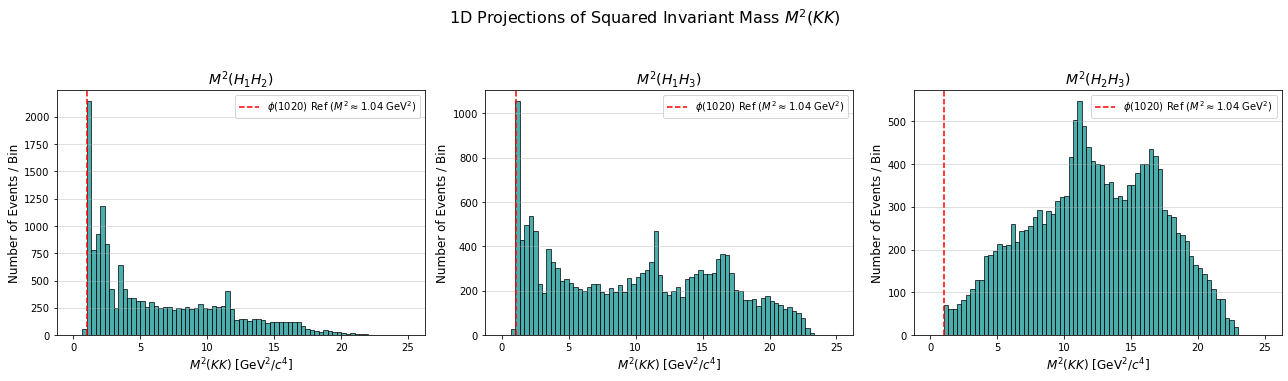


Successfully generated the 1D projections of the three two-body invariant mass squared combinations.
Look for sharp peaks on these plots, especially around 1.04 GeV^2, which would indicate a strong resonance signal.


In [10]:
# --- 2. Plotting Parameters ---
# Typical max mass for K+K- pairs from B decay is ~23 GeV^2 (since M_B is ~5.28 GeV)
HIST_RANGE = (0, 25) 
HIST_BINS = 75 

# --- 3. Create Figure and Subplots (1x3 Layout) ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.suptitle(r'1D Projections of Squared Invariant Mass $M^2(K K)$', fontsize=16, y=1.05)

# Variables to plot
M_sq_vars = [M_sq_12_GeV, M_sq_13_GeV, M_sq_23_GeV]
titles = [r'$M^2(H_1 H_2)$', r'$M^2(H_1 H_3)$', r'$M^2(H_2 H_3)$']

# --- 4. Loop and Plot ---
for i, (data_arr, title) in enumerate(zip(M_sq_vars, titles)):
    ax = axes[i]
    
    # Plot the histogram
    ax.hist(data_arr, bins=HIST_BINS, range=HIST_RANGE, 
            color='darkcyan', edgecolor='black', alpha=0.7)
    
    # Draw reference lines for known Kaon-Kaon resonances (optional, but helpful for analysis)
    # Example: M^2 of phi(1020) is ~1.04 GeV^2
    M_PHI = 1.019  # GeV
    M_PHI_SQ = M_PHI**2
    
    if M_PHI_SQ > HIST_RANGE[0] and M_PHI_SQ < HIST_RANGE[1]:
        ax.axvline(M_PHI_SQ, color='red', linestyle='--', linewidth=1.5, 
                   label=r'$\phi(1020)$ Ref ($M^2 \approx 1.04$ GeV$^2$)')
    
    # Set labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'$M^2(K K)$ [GeV$^2$/$c^4$]', fontsize=12)
    ax.set_ylabel('Number of Events / Bin', fontsize=12)
    ax.legend()
    ax.grid(axis='y', alpha=0.5)

# --- 5. Final Layout ---
plt.tight_layout()
plt.show()

print("\nSuccessfully generated the 1D projections of the three two-body invariant mass squared combinations.")
print("Look for sharp peaks on these plots, especially around 1.04 GeV^2, which would indicate a strong resonance signal.")

#

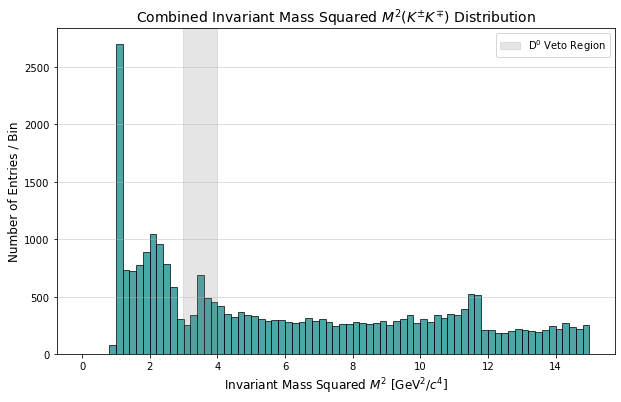

In [24]:
# --- 1. Combine M^2_A and M^2_B into a single array ---
M_sq_combined_GeV = np.concatenate((M_sq_A_GeV, M_sq_B_GeV))

# --- 2. Define Plotting Parameters ---
# The expected resonances (like phi(1020), f0(980), etc.) are at low M^2.
HIST_RANGE = (0, 15) # M^2 range in GeV^2/c^4
NBINS = 75

# --- 3. Plot Combined Distribution ---
plt.figure(figsize=(10, 6))

plt.hist(M_sq_combined_GeV, bins=NBINS, range=HIST_RANGE, 
         color='teal', alpha=0.7, edgecolor='black', density=False)

# Add D^0 veto region boundaries for context (already applied in the sample, but good for visualization)
# D^0 mass is ~1865 MeV/c^2. M^2 ~ 3.48 GeV^2/c^4. Our Veto was around this region.
M_D0_SQ_REF = 3.48
plt.axvspan(M_D0_SQ_REF - 0.5, M_D0_SQ_REF + 0.5, color='gray', alpha=0.2, label=r'D$^0$ Veto Region')


# --- 5. Labels and Show ---
plt.title(r'Combined Invariant Mass Squared $M^2(K^{\pm}K^{\mp})$ Distribution', fontsize=14)
plt.xlabel(r'Invariant Mass Squared $M^2$ [GeV$^2$/$c^4$]', fontsize=12)
plt.ylabel('Number of Entries / Bin', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

We will explain why $D^0$ vetoed in the following sections.


--- Plotting Optimized Dalitz Plots ---


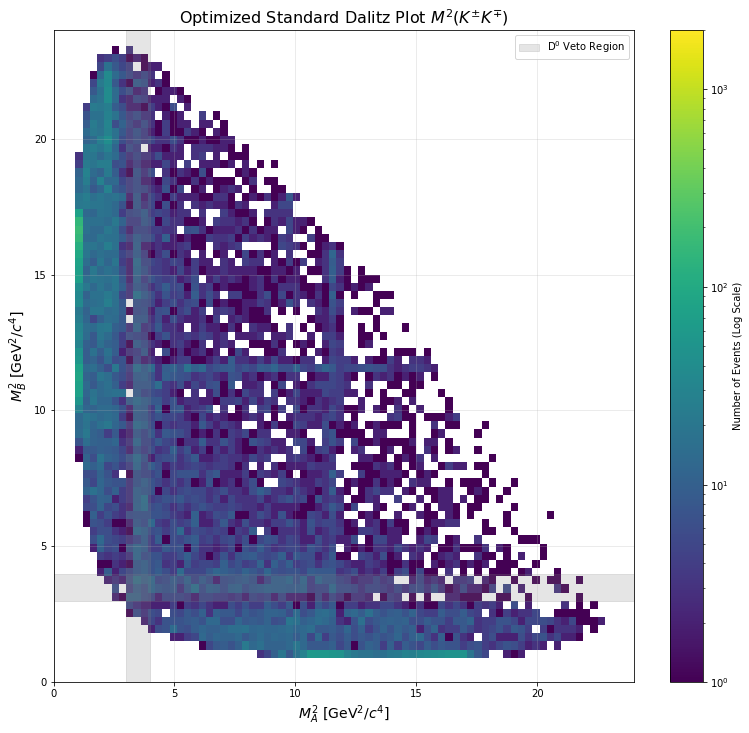

In [26]:
 # Reference line for the squared mass of the D0 meson
M_D0_SQ_REF = 3.48 

print("\n--- Plotting Optimized Dalitz Plots ---")

# --- 3. Optimized Standard Dalitz Plot (Task 1 & 2) ---
plt.figure(figsize=(13, 12))
# Plotting M^2_A vs M^2_B
plt.hist2d(M_sq_A_GeV, M_sq_B_GeV, 
           bins=80, 
           range=[(0, 24), (0, 24)], # Apply range to both axes
           cmap='viridis', 
           norm=LogNorm(vmin=1, vmax=2000)) # Use LogNorm for better visualization of low-density regions
           
plt.colorbar(label=r'Number of Events (Log Scale)')
plt.title(r'Optimized Standard Dalitz Plot $M^2(K^{\pm} K^{\mp})$', fontsize=16)
plt.xlabel(r'$M^2_{A}$ [GeV$^2$/$c^4$]', fontsize=14)
plt.ylabel(r'$M^2_{B}$ [GeV$^2$/$c^4$]', fontsize=14)

# Draw reference lines to highlight expected resonance bands (e.g., phi(1020))
plt.axvspan(M_D0_SQ_REF - 0.5, M_D0_SQ_REF + 0.5, color='gray', alpha=0.2, label=r'D$^0$ Veto Region')
plt.axhspan(M_D0_SQ_REF - 0.5, M_D0_SQ_REF + 0.5, color='gray', alpha=0.2)

plt.grid(alpha=0.3)
plt.legend()
#plt.savefig('Optimized_Standard_Dalitz_Plot.png')
#print("Optimized Standard Dalitz Plot saved.")

#

### Ordering Dalitz variables
You can make a further improvement to allow you to observe the resonances easier. Your resonances R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub> are both composed of the same particle types, K<sup>+</sup>K<sup>-</sup>, and hence have the same distributions. It is useful to impose an ordering which distinguishes the resonances. We can call the resonances R<sup>0</sup><sub>Low</sub> and R<sup>0</sup><sub>High</sub>. In each event R<sup>0</sup><sub>Low</sub> is the resonance with the lower mass and the other corresponds to the higher mass combination of kaons. You can now use the mass of these ordered resonances as your Dalitz plot variables, thus effectively "folding" your Dalitz plot so that one axis always has a higher value than the other.


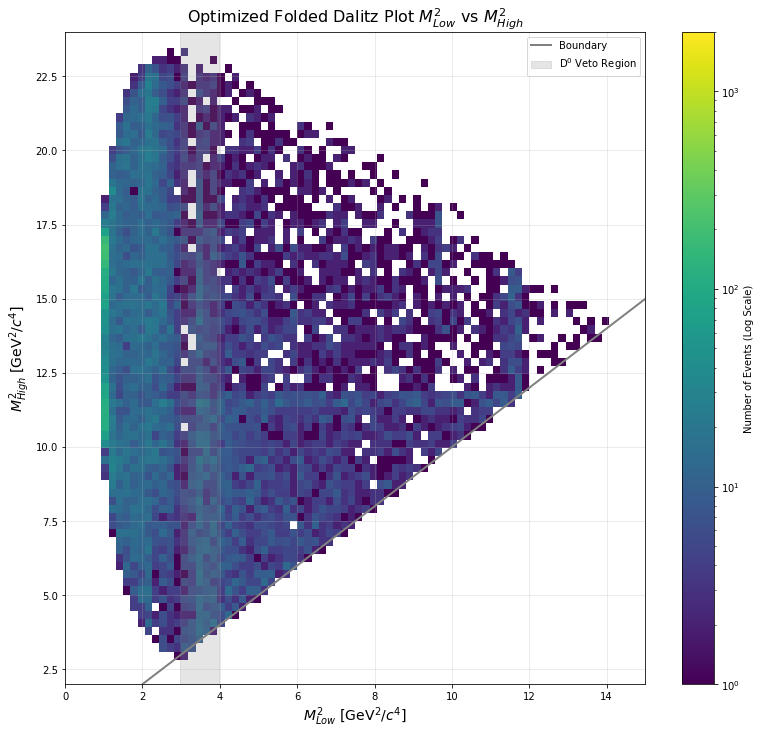

In [28]:
# --- 4. Optimized Folded Dalitz Plot (Task 3) ---
plt.figure(figsize=(13, 12))
# Plotting M^2_Low vs M^2_High
plt.hist2d(M_sq_Low_GeV, M_sq_High_GeV, 
           bins=80, 
           range=[(0,15), (2,24)], # Apply range to both axes
           cmap='viridis', 
           norm=LogNorm(vmin=1, vmax=2000))
           
plt.colorbar(label=r'Number of Events (Log Scale)')
plt.title(r'Optimized Folded Dalitz Plot $M^2_{Low}$ vs $M^2_{High}$', fontsize=16)
plt.xlabel(r'$M^2_{Low}$ [GeV$^2$/$c^4$]', fontsize=14)
plt.ylabel(r'$M^2_{High}$ [GeV$^2$/$c^4$]', fontsize=14)

# Draw the boundary line (M_sq_Low = M_sq_High)
x_min, x_max = plt.xlim()
plt.plot([x_min, x_max], [x_min, x_max], color='grey', linestyle='-', linewidth=2, label='Boundary')

plt.axvspan(M_D0_SQ_REF - 0.5, M_D0_SQ_REF + 0.5, color='gray', alpha=0.2, label=r'D$^0$ Veto Region')

plt.grid(alpha=0.3)
plt.legend(loc='upper right')
#plt.savefig('Optimized_Folded_Dalitz_Plot.png')
#print("Optimized Folded Dalitz Plot saved.")

## Two body resonances

You can now use your Dalitz plot to identify the intermediate resonances that you see in your plots. The resonances will have shown up as bands of higher density of points on the plots. You can use the [particle data group](http://pdg.lbl.gov/2015/tables/contents_tables.html) tables of mesons to identify which particles these correspond to. The tables give the masses and widths of the particles and their decay modes. You are looking for mesons with the masses corresponding to where you see the bands and that decay into K<sup>+</sup>K<sup>-</sup>.

**Congratulations!** You have succesfully made a Dalitz plot and used it to observe the presence of intermediate particles in the decay of your charged B meson into three charged kaons. 

# Searching for local matter anti-matter differences
## Aims:
* Observe matter antimatter differences (CP violation) in regions of the Dalitz plots of the B<sup>+</sup> and B<sup>-</sup> mesons.
* For the data in these regions produce plots to best display the CP violation.

In a section above you searched for global CP violation. You probably did not find a result with very high significance. 

CP violation may arise from interference between decays through different resonances, and hence the magnitude and sign of the CP violation may vary across the Dalitz plot. We can apply the same equation as in the global CP violation study,
but apply this only to events in particular regions of the Dalitz plot.


## Removing charm resonances

The analysis performed here is to study the CP violation in the charmless B meson decays to kaons. "charmless" means that the decay does not proceed through a charm quark. However, the most frequent decay of the B mesons occur through the *b* quark decaying into a *c* quark. The majority of these events can be removed by rejecting the events that are proceeding through a D<sup>0</sup> meson (which contains the charm quark).

In the section above you plotted a histogram of the invariant mass of the intermediate resonances and will have observed the D<sup>0</sup> meson in this and in the Dalitz plot. You should now reject events that are around the mass range of the D<sup>0</sup> meson to suppress this contribution. You can do this in your pre-selection on the data that you set-up earlier in the project.

This was also a simplification that we did not consider when we were calculating the global asymmetry. After you have applied this pre-selection your code will now recompute the global asymmetry with the D<sup>0</sup> meson contribution rejected. We have not yet observed CP violation in charm mesons and searching for this is another active area of current research.

## Comparing Dalitz plots

Make separate Dalitz plots for the B<sup>+</sup> and the B<sup>-</sup> decays.
Local CP Violation will show up as an asymmetry between the B<sup>+</sup> and the B<sup>-</sup> plots.  

In order that the statistical error on the asymmetry in each bin is not over large the bins need to contain a reasonable number of entries. Hence you will probably need larger bins than when you were looking for resonances in the section above. A suitable initial bin size might be $2.5~\text{GeV}^2/\text{c}^4 \times 2.5~\text{GeV}^2/\text{c}^4$.


--- Applying D0 Veto for Charmless Selection ---
Events before D0 Veto: 16,685
Events after D0 Veto: 15,397
B+ Events (N+): 8,117
B- Events (N-): 7,280

--- Global Asymmetry Re-calculated (Charmless Sample) ---
Charmless Global Asymmetry (A_charmless): -0.0544 +/- 0.0080


/scratch/condor/dir_3651719/ipykernel_3713273/2132105284.py:110: RuntimeWarning: invalid value encountered in divide
  A_bin = np.where(N_sum > 0, N_diff / N_sum, 0)


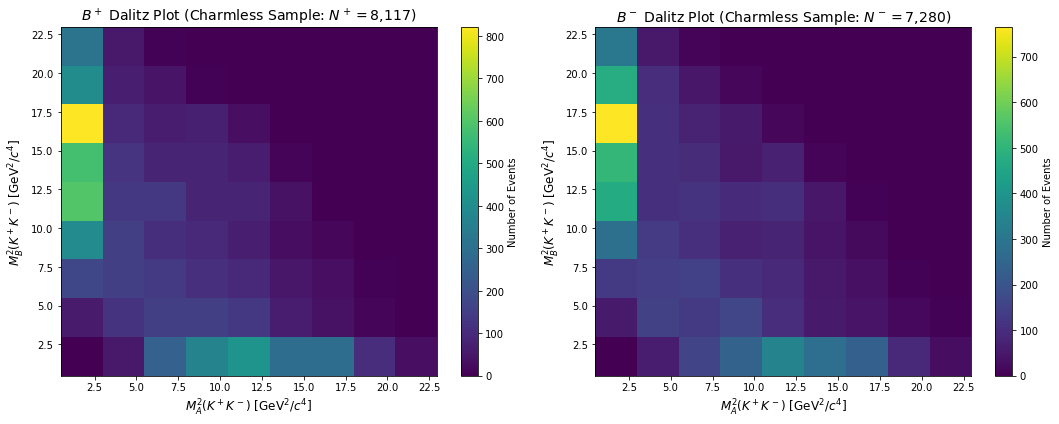

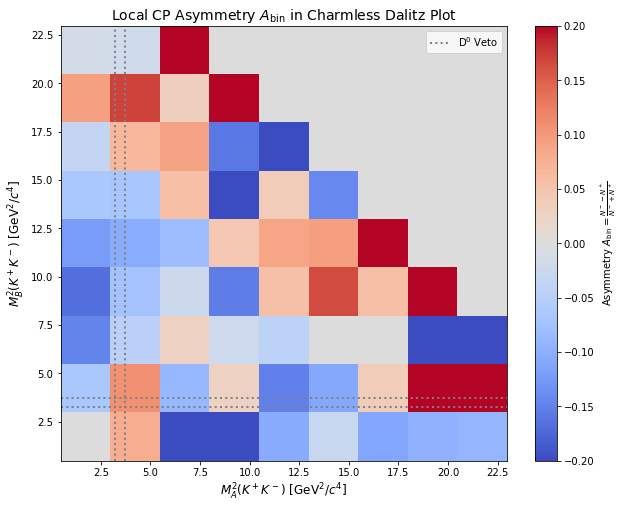

In [29]:
from matplotlib.colors import Normalize

# --- 0. Constants and Initial Data Setup ---
# D0 meson mass (in MeV/c^2)
M_D0 = 1864.84
# D0 mass window to veto (MeV/c^2). Typically +/- 3 sigma or similar.
# We'll use a window around D0 mass squared (~3.476e6 MeV^2/c^4)
M_D0_SQ = M_D0**2
D0_WINDOW = 500**2  # A wide window of +/- 500 MeV/c^2 squared is often used for vetoing.

# --- 1. D-zero Veto (Selection Improvement) ---

print("--- Applying D0 Veto for Charmless Selection ---")

# Calculate the M^2 range to veto
VETO_MIN_SQ = M_D0_SQ - D0_WINDOW
VETO_MAX_SQ = M_D0_SQ + D0_WINDOW

# The D0 veto mask: Reject events where *any* K+K- combination is near the D0 mass.
# Remember M_sq_A and M_sq_B are the two K+K- combinations.
d0_veto_A = (M_sq_A < VETO_MIN_SQ) | (M_sq_A > VETO_MAX_SQ)
d0_veto_B = (M_sq_B < VETO_MIN_SQ) | (M_sq_B > VETO_MAX_SQ)

# Final mask for charmless analysis (must pass B peak AND D0 veto)
# Note: We keep events that are *outside* the veto region.
charmless_mask = d0_veto_A & d0_veto_B

# Apply the new mask to the B peak events
dalitz_data_charmless = dalitz_data[charmless_mask].copy()
M_sq_A_charmless = M_sq_A[charmless_mask]
M_sq_B_charmless = M_sq_B[charmless_mask]

# Recalculate N+ and N- for the charmless sample
N_plus_charmless = len(dalitz_data_charmless.query('B_Charge == 1'))
N_minus_charmless = len(dalitz_data_charmless.query('B_Charge == -1'))
N_total_charmless = N_plus_charmless + N_minus_charmless

print(f"Events before D0 Veto: {len(dalitz_data):,}")
print(f"Events after D0 Veto: {len(dalitz_data_charmless):,}")
print(f"B+ Events (N+): {N_plus_charmless:,}")
print(f"B- Events (N-): {N_minus_charmless:,}")

# Recalculate Global Asymmetry (A_charmless) after D0 Veto
A_charmless = (N_minus_charmless - N_plus_charmless) / N_total_charmless if N_total_charmless > 0 else 0
sigma_A_charmless = np.sqrt(np.abs(1 - A_charmless**2) / N_total_charmless) if N_total_charmless > 0 else np.nan

print("\n--- Global Asymmetry Re-calculated (Charmless Sample) ---")
print(f"Charmless Global Asymmetry (A_charmless): {A_charmless:.4f} +/- {sigma_A_charmless:.4f}")

# --- 2. Separate Data and Define Binning ---

# Separate B+ and B- events
M_sq_A_plus = M_sq_A_charmless[dalitz_data_charmless['B_Charge'] == 1]
M_sq_B_plus = M_sq_B_charmless[dalitz_data_charmless['B_Charge'] == 1]

M_sq_A_minus = M_sq_A_charmless[dalitz_data_charmless['B_Charge'] == -1]
M_sq_B_minus = M_sq_B_charmless[dalitz_data_charmless['B_Charge'] == -1]

# Define binning (Using M^2 in GeV^2/c^4 for plotting)
# Convert from MeV^2/c^4 to GeV^2/c^4
M_sq_A_plus_GeV = M_sq_A_plus / 1e6
M_sq_B_plus_GeV = M_sq_B_plus / 1e6
M_sq_A_minus_GeV = M_sq_A_minus / 1e6
M_sq_B_minus_GeV = M_sq_B_minus / 1e6

# Determine the overall range and bin width (2.5 GeV^2/c^4)
range_min = min(M_sq_A_plus_GeV.min(), M_sq_A_minus_GeV.min(), M_sq_B_plus_GeV.min(), M_sq_B_minus_GeV.min())
range_max = max(M_sq_A_plus_GeV.max(), M_sq_A_minus_GeV.max(), M_sq_B_plus_GeV.max(), M_sq_B_minus_GeV.max())
range_buffer = 0.5 # Add a small buffer

# Define the common bin edges based on the suggested bin size
BIN_SIZE = 2.5
bins = np.arange(range_min - range_buffer, range_max + range_buffer, BIN_SIZE)

# --- 3. Make Separate Dalitz Plots (B+ and B-) ---
plt.figure(figsize=(15, 6))

# Subplot 1: B+ Dalitz Plot
ax1 = plt.subplot(1, 2, 1)
H_plus, xedges, yedges, img_plus = ax1.hist2d(M_sq_A_plus_GeV, M_sq_B_plus_GeV, bins=[bins, bins], cmap='viridis')
ax1.set_title(r'$B^+$ Dalitz Plot (Charmless Sample: $N^+=$' + f'{N_plus_charmless:,})', fontsize=14)
ax1.set_xlabel(r'$M^2_{A}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
ax1.set_ylabel(r'$M^2_{B}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
plt.colorbar(img_plus, ax=ax1, label='Number of Events')

# Subplot 2: B- Dalitz Plot
ax2 = plt.subplot(1, 2, 2)
H_minus, xedges, yedges, img_minus = ax2.hist2d(M_sq_A_minus_GeV, M_sq_B_minus_GeV, bins=[bins, bins], cmap='viridis')
ax2.set_title(r'$B^-$ Dalitz Plot (Charmless Sample: $N^-=$' + f'{N_minus_charmless:,})', fontsize=14)
ax2.set_xlabel(r'$M^2_{A}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
ax2.set_ylabel(r'$M^2_{B}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
plt.colorbar(img_minus, ax=ax2, label='Number of Events')

plt.tight_layout()
#plt.savefig('B_plus_minus_Dalitz_Plots.png')
#print("Successfully generated B+ and B- Dalitz Plots: B_plus_minus_Dalitz_Plots.png")

# 

# --- 4. Make Asymmetry Plot (A_bin) ---
plt.figure(figsize=(10, 8))

# Calculate the asymmetry in each bin
# A_bin = (N⁻_bin - N⁺_bin) / (N⁻_bin + N⁺_bin)
# Use np.divide and np.where to handle division by zero (bins with zero total entries)
N_sum = H_plus + H_minus
N_diff = H_minus - H_plus

# Calculate A_bin. If N_sum is zero, A_bin is set to 0 (or nan, but 0 is better for plotting)
A_bin = np.where(N_sum > 0, N_diff / N_sum, 0)

# Create the 2D plot for asymmetry
# We must use pcolormesh or imshow, as hist2d returns the count grid, not the image.
# We transpose H_plus/H_minus because hist2d outputs in a (x_bins, y_bins) array structure.
X, Y = np.meshgrid(xedges, yedges)
im = plt.pcolormesh(X, Y, A_bin.T, cmap='coolwarm', norm=Normalize(vmin=-0.2, vmax=0.2)) # Use a diverging colormap

# Add D0 veto region boundary for context
plt.axhline(VETO_MIN_SQ/1e6, color='gray', linestyle=':', linewidth=2, label=r'D$^0$ Veto')
plt.axhline(VETO_MAX_SQ/1e6, color='gray', linestyle=':', linewidth=2)
plt.axvline(VETO_MIN_SQ/1e6, color='gray', linestyle=':', linewidth=2)
plt.axvline(VETO_MAX_SQ/1e6, color='gray', linestyle=':', linewidth=2)

plt.colorbar(im, label=r'Asymmetry $A_{\text{bin}} = \frac{N^- - N^+}{N^- + N^+}$')
plt.title(r'Local CP Asymmetry $A_{\text{bin}}$ in Charmless Dalitz Plot', fontsize=14)
plt.xlabel(r'$M^2_{A}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
plt.ylabel(r'$M^2_{B}(K^+K^-)$ [GeV$^2$/$c^4$]', fontsize=12)
plt.legend()
#plt.savefig('Local_CP_Asymmetry_Plot.png')
#print("Successfully generated Local CP Asymmetry Plot: Local_CP_Asymmetry_Plot.png")

#

Observing a large asymmetry in some regions of the plot does not necessarily mean you have observed CP violation. If there are very few events in that region of the plot the uncertainty on that large asymmetry may be large. Hence, the value may still be compatible with zero.

You can calculate the statistical uncertainty on the asymmetry, for each bin of the plot, using the same formulas as you used in the global asymmetry section. You can then make a plot showing the uncertainty on the asymmetry.

Dividing the plot showing the asymmetry by the plot showing the statistical uncertainty you can then obtain the significance of the asymmetry in each bin. You can then plot the significance of the asymmetry to see if there is any evidence for CP violation.

/scratch/condor/dir_3651719/ipykernel_3713273/775780443.py:5: RuntimeWarning: divide by zero encountered in divide
  sigma_A_sq = np.where(N_sum > 0, np.abs(1 - A_bin**2) / N_sum, 0)
/scratch/condor/dir_3651719/ipykernel_3713273/775780443.py:24: RuntimeWarning: divide by zero encountered in divide
  Z_bin = np.where(sigma_A_bin > 0, A_bin / sigma_A_bin, 0)
/scratch/condor/dir_3651719/ipykernel_3713273/775780443.py:24: RuntimeWarning: invalid value encountered in divide
  Z_bin = np.where(sigma_A_bin > 0, A_bin / sigma_A_bin, 0)


Text(0, 0.5, '$M^2_{B}(K^{\\pm} K^{\\mp})$ [GeV$^2$/$c^4$]')

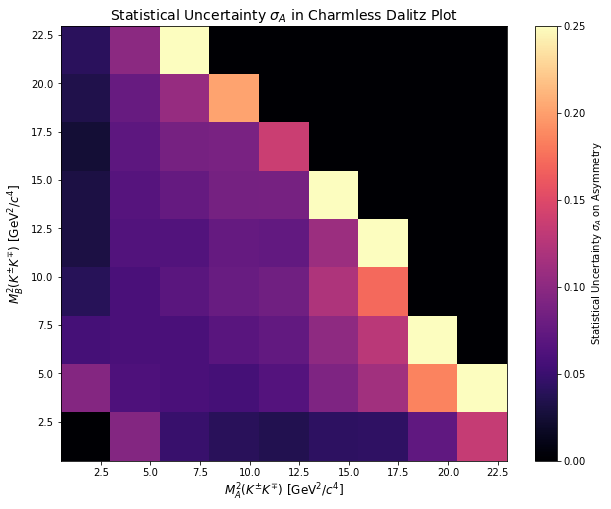

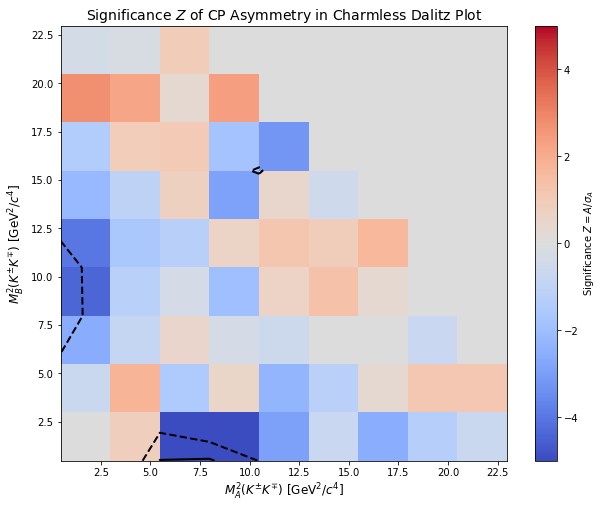

In [49]:
# --- 1. Calculate Statistical Uncertainty (sigma_A_bin) ---

# Uncertainty formula: sigma_A = sqrt((1 - A^2) / N_total)
# Use np.where to safely handle bins where N_sum is zero (set uncertainty to 0 for these bins).
sigma_A_sq = np.where(N_sum > 0, np.abs(1 - A_bin**2) / N_sum, 0)
sigma_A_bin = np.sqrt(sigma_A_sq)

# --- 2. Plot Uncertainty (sigma_A_bin) ---
plt.figure(figsize=(10, 8))

# Use pcolormesh for 2D plotting with a sequential colormap (magma)
im_sigma = plt.pcolormesh(X, Y, sigma_A_bin.T, cmap='magma', norm=Normalize(vmin=0, vmax=0.25))

plt.colorbar(im_sigma, label=r'Statistical Uncertainty $\sigma_{A}$ on Asymmetry')
plt.title(r'Statistical Uncertainty $\sigma_{A}$ in Charmless Dalitz Plot', fontsize=14)
plt.xlabel(r'$M^2_{A}(K^{\pm} K^{\mp})$ [GeV$^2$/$c^4$]', fontsize=12)
plt.ylabel(r'$M^2_{B}(K^{\pm} K^{\mp})$ [GeV$^2$/$c^4$]', fontsize=12)
# 

# --- 3. Calculate Significance (Z_bin) ---

# Significance formula: Z = A / sigma_A
# Use np.where to safely handle bins where sigma_A_bin is 0 (set Z to 0)
Z_bin = np.where(sigma_A_bin > 0, A_bin / sigma_A_bin, 0)

# --- 4. Plot Significance (Z_bin) ---
plt.figure(figsize=(10, 8))

# Set visualization range for Z. We often cap at +/- 5 sigma for better visualization.
Z_MAX_PLOT = 5.0 
Z_MIN_PLOT = -5.0

# Use pcolormesh for 2D plotting with a diverging colormap (coolwarm)
im_Z = plt.pcolormesh(X, Y, Z_bin.T, cmap='coolwarm', norm=Normalize(vmin=Z_MIN_PLOT, vmax=Z_MAX_PLOT))

# Plot the 3-sigma boundaries (Evidence threshold)
# We plot contours on the original grid (X[:-1, :-1], Y[:-1, :-1])
plt.contour(X[:-1, :-1], Y[:-1, :-1], Z_bin.T, 
            levels=[-5,-3, 3,5], colors='black', linestyles=['-','--', '--','-'], 
            linewidths=[2, 2])

plt.colorbar(im_Z, label=r'Significance $Z = A / \sigma_{A}$')
plt.title(r'Significance $Z$ of CP Asymmetry in Charmless Dalitz Plot', fontsize=14)
plt.xlabel(r'$M^2_{A}(K^{\pm} K^{\mp})$ [GeV$^2$/$c^4$]', fontsize=12)
plt.ylabel(r'$M^2_{B}(K^{\pm} K^{\mp})$ [GeV$^2$/$c^4$]', fontsize=12)

## Results Interpretation

After analyzing the CP asymmetry across the Dalitz plot, you will see two key visualizations. Here's how to interpret them:

### 1. **Uncertainty Plot ($\sigma_A$)**
This plot shows the statistical uncertainty in each bin of the Dalitz plot.

- **Color coding:** Typically uses a gradient from dark (low uncertainty) to light (high uncertainty)
- **Interpretation:** Regions with more events (higher statistics) will have lower uncertainty
  - **Dalitz plot boundaries:** Often have higher event counts and therefore lower uncertainty
  - **Resonance bands:** Areas corresponding to known particle resonances may show characteristic patterns
  - **Sparse regions:** Central areas with fewer events will have higher uncertainty (lighter colors)

### 2. **Significance Plot ($Z$ value)**
This is the primary result showing evidence for local CP violation.

- **What $Z$ represents:** The number of standard deviations by which the bin asymmetry $A_{\text{bin}}$ deviates from zero
- **Color scheme:** Typically uses a divergent color scale (e.g., blue for negative $Z$, red for positive $Z$)
- **Thresholds for interpretation:**

  | $Z$ value | Interpretation in Particle Physics |
  |-----------|-------------------------------------|
  | $Z \ge 3$ | **Strong Evidence** - Shown as regions enclosed by black dashed lines (typically bright red or blue) |
  | $Z \ge 5$ | **Observation/Discovery** - Conclusive evidence for local CP violation |

- **Practical guidance:**
  - Look for contiguous regions with $Z \ge 3$ (significantly different from background fluctuations)
  - Consider both the magnitude and spatial coherence of significant regions
  - Remember that statistical fluctuations can create isolated high-$Z$ bins; patterns are more convincing than isolated points

### Connection to Global Analysis
Compare these local results with the global CP asymmetry calculated earlier. Consistent patterns across multiple bins provide stronger evidence than the global measurement alone.

**Note:** These visualizations are based on the specific selection criteria you applied. Different cuts may yield different patterns, which is why systematic studies are crucial in particle physics analyses.

## Observing CP violation

From your studies of the asymmetry plot, and the plot of its significance, you will be able to identify regions in the Dalitz plots that show indications of sizeable and significant CP Violation. You may find you have several consecutive bins with significant positive, or negative, asymmetries. You may wish to try alternative binnings of the Dalitz plots to best isolate the regions in which the significant asymmetries occur.

You can select events that are in these regions of the Dalitz plots where you observe signs of CP Violation. You can then plot a simple 1D histogram of the invariant mass distribution of the B<sup>+</sup> and the B<sup>-</sup> events, just as you did at the start of the project, but only for events that lie in the region of the Dalitz plot that you are interested in. Make the plots of the B<sup>+</sup> and the B<sup>-</sup> events with the same scale, or superimpose the two plots, so that you can observe if the particle and anti-particle decay processes are occurring at the same rate.

--- Selecting ROI based on Statistical Significance: |Z| >= 3.0 sigma ---
Total events selected in the |Z| >= 3.0 sigma ROI: 2,788


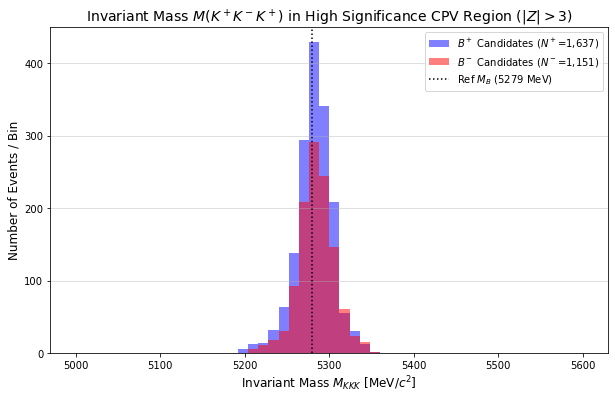

In [42]:
# --- 1. Define and apply ROI selection based on significance (|Z| >= 3) ---
Z_THRESHOLD = 3.0
print(f"--- Selecting ROI based on Statistical Significance: |Z| >= {Z_THRESHOLD} sigma ---")

# a.  M^2 unit convertion MeV^2/c^4 -> GeV^2/c^4 
M_sq_A_GeV = M_sq_A_charmless / 1e6
M_sq_B_GeV = M_sq_B_charmless / 1e6

# b. Ensure every event falling into the corresponding coloumn of Z_bin array
N_bins = len(bins) - 1

idx_x = np.digitize(M_sq_A_GeV, bins) - 1
idx_y = np.digitize(M_sq_B_GeV, bins) - 1

idx_x = np.clip(idx_x, 0, N_bins - 1)
idx_y = np.clip(idx_y, 0, N_bins - 1)

# c. Check the Z_bin values of each event satisfies |Z| >= 3
# Z_bin structure: (x_bins, y_bins)
roi_mask_events = np.abs(Z_bin[idx_x, idx_y]) >= Z_THRESHOLD

# d. filter
dalitz_data_ROI = dalitz_data_charmless[roi_mask_events].copy()

print(f"Total events selected in the |Z| >= {Z_THRESHOLD} sigma ROI: {len(dalitz_data_ROI):,}")

# --- 2. calculate B meson mass M(KKK) in ROI events  ---
M_KAON = 493.677 
def calculate_invariant_mass(data, mass_hypothesis):
    # (Simplified momentum and energy calculation for readability)
    P_sq_H1 = data['H1_PX']**2 + data['H1_PY']**2 + data['H1_PZ']**2
    # ... and similarly for H2, H3
    P_sq_H2 = data['H2_PX']**2 + data['H2_PY']**2 + data['H2_PZ']**2
    P_sq_H3 = data['H3_PX']**2 + data['H3_PY']**2 + data['H3_PZ']**2
    
    E_H1 = np.sqrt(P_sq_H1 + M_KAON**2)
    E_H2 = np.sqrt(P_sq_H2 + M_KAON**2)
    E_H3 = np.sqrt(P_sq_H3 + M_KAON**2)
    
    P_total_x = data['H1_PX'] + data['H2_PX'] + data['H3_PX']
    # ... and similarly for Y, Z
    P_total_y = data['H1_PY'] + data['H2_PY'] + data['H3_PY']
    P_total_z = data['H1_PZ'] + data['H2_PZ'] + data['H3_PZ']
    P_total_sq = P_total_x**2 + P_total_y**2 + P_total_z**2
    
    E_total = E_H1 + E_H2 + E_H3
    M_sq = E_total**2 - P_total_sq
    return np.sqrt(np.maximum(M_sq, 0))

invariant_mass_ROI = calculate_invariant_mass(dalitz_data_ROI, M_KAON)

# --- 3. separate B+ & B- ---
mass_B_plus_ROI = invariant_mass_ROI[dalitz_data_ROI['B_Charge'] == 1]
mass_B_minus_ROI = invariant_mass_ROI[dalitz_data_ROI['B_Charge'] == -1]

# --- 4. Plot ---
plt.figure(figsize=(10, 6))

MASS_RANGE = (5000, 5600)
NBINS = 50

#  B+ (blue)
plt.hist(mass_B_plus_ROI, bins=NBINS, range=MASS_RANGE, 
         color='blue', alpha=0.5, label=r'$B^+$ Candidates ($N^+$=' + f'{len(mass_B_plus_ROI):,})')

#  B- (red)
plt.hist(mass_B_minus_ROI, bins=NBINS, range=MASS_RANGE, 
         color='red', alpha=0.5, label=r'$B^-$ Candidates ($N^-$=' + f'{len(mass_B_minus_ROI):,})')

#  B meson mass line
M_B_REF = 5279.32 
plt.axvline(M_B_REF, color='black', linestyle=':', linewidth=1.5, label=f'Ref $M_B$ ({M_B_REF:.0f} MeV)')

# label
plt.title(r'Invariant Mass $M(K^+K^-K^+)$ in High Significance CPV Region ($|Z| > 3$)', fontsize=14)
plt.xlabel(r'Invariant Mass $M_{KKK}$ [MeV/$c^2$]', fontsize=12)
plt.ylabel('Number of Events / Bin', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

In [44]:
Nbinned_plus = len(mass_B_plus_ROI)
Nbinned_minus =len(mass_B_minus_ROI)
Nbinned_total = Nbinned_plus + Nbinned_minus

# --- 3. Calculate Asymmetry (A) ---
if Nbinned_total == 0:
    Abinned, sigma_Abinned, Zbinned = np.nan, np.nan, np.nan
    print("ERROR: Total event count is zero. Cannot calculate asymmetry.")
else:
    Abinned = (Nbinned_minus - Nbinned_plus) / Nbinned_total
    
    sigma_Abinned = np.sqrt(np.abs(1 - Abinned**2) / Nbinned_total)
    
    # --- 5. Calculate Significance (Z) ---
    if sigma_Abinned != 0:
        Zbinned = np.abs(Abinned / sigma_Abinned)
    else:
        Zbinned = np.nan


print("--- Local CP Asymmetry Calculation ---")
print(f"B+ Events (N+): {Nbinned_plus:,}")
print(f"B- Events (N-): {Nbinned_minus:,}")
print(f"Total Events (N): {Nbinned_total:,}")
print("-" * 35)
print(f"Local Asymmetry in ROI (A): {Abinned:.4f}")
print(f"Statistical Uncertainty (sigma_A): {sigma_Abinned:.4f}")
print("-" * 35)
print(f"Significance (Z value): {Zbinned:.2f} sigma")

# Check for evidence/observation based on particle physics conventions
if Zbinned >= 5:
    print("Conclusion: Evidence for CP violation reaches the OBSERVATION level (>= 5 sigma).")
elif Zbinned >= 3:
    print("Conclusion: There is STRONG EVIDENCE for CP violation (>= 3 sigma).")
else:
    print("Conclusion: No statistically significant evidence for global CP violation in this decay sample (Z < 3 sigma).")

--- Local CP Asymmetry Calculation ---
B+ Events (N+): 1,637
B- Events (N-): 1,151
Total Events (N): 2,788
-----------------------------------
Local Asymmetry in ROI (A): -0.1743
Statistical Uncertainty (sigma_A): 0.0186
-----------------------------------
Significance (Z value): 9.35 sigma
Conclusion: Evidence for CP violation reaches the OBSERVATION level (>= 5 sigma).


**Congratulations!** You should now have succesfully observed significant evidence for CP Violation. You should have plots that clearly show that particle and anti-particle decay processes occur at different rates in local regions of the Dalitz plot. You may wish to comapre your results with those published by the LHCb collaboration in this [paper](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-027.html).

**Well Done** you have succesfully completed your first particle physics analysis project. There are many more analyses that can be conducted witht the data set that you have been provided and the skills that you have gained. Ideas for some of these are explored in the section below. Maybe you can discover something new!



# Further analyses

The data set you have been provided is the full set of data recorded by LHCb preselected for decays of charged B mesons into three final state tracks. This data set has been used for two important publications, [here](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-027.html) and [here](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-051.html).

We discuss here: 
<ul>
<li>Additional elements that you could add to your analysis of B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> </li>
<li>Further analyses that you could perform with this data set</li>
</ul>

## Adding extra sophistication

### Systematic Uncertainties
In this analysis you considered the statistical uncertainty on the result. This occurs as a result of having only a limited number of events. In addition there are [systematic uncertainties](https://en.wikipedia.org/wiki/Observational_error#Systematic_versus_random_error), these arise from biases in your measurement. Here we discuss three sources of these for this analysis.
<ul>
<li> Production asymmetry. The LHC is a proton-proton collider and hence the initial state of the collision is not matter antimatter symmetric. Consequently B<sup>+</sup> and B<sup>-</sup> mesons may not be produced at exactly the same rates. This small production asymmetry it is estimated could be approximately 1%. It can also be measured from the data, as discussed in the LHCb paper.</li>
<li> Detection asymmetry. The LHCb detector could be more efficient for detecting either the B<sup>+</sup> or the B<sup>-</sup> final states. This is because the positive and negative kaons will be bent by the magnet indifferent directions in the detector. If the efficiency of the detector is higher in one region than another this will lead to higher efficiencies for K<sup>+</sup> or K<sup>-</sup> and hence for B<sup>+</sup> or B<sup>-</sup>. For this reason the magnetic field of the LHCb detector is regularly reversed. You used data in this analysis in which the magnetic field was both up and down and hence the effect will (partially) cancel. By comparing results for the two magnet polarities separately you can check the size of this effect. When loading the data above both polarities were combined, you can instead load them independently to measure the difference between the two datasets.</li>
<li> Analysis technique. The analysis technique you have used may bias the result. A major simplification we made in the analysis above was to neglect 'background' events. We imposed a selection to select a sample of predominantly signal events but have not accounted for the effect of the residual background events.</li>
</ul>

### Using mass sidebands

One source of 'background' events arises from random combinations of tracks in events that happen to fake the 'signal' characteristics. These events will not peak in the mass distribution at the mass of the B meson but rtaher will have a smoothly varying distribution. Looking at the number and distribution of of events away from the mass peak can allow you to estimate the number of background events under the mass peak.

### Fitting distributions

The next level of sophistication in the analysis requires fitting the distributions of events that are observed in the B mass distribution in order to estimate the yield of signal events and background events. You can see how this is done in the LHCb paper on the analysis. Fitting can be performed using the [CERN root framework](https://root.cern.ch/).

## Further analyses

The LHCb papers using this data set that you are using analysed four decay channels of the charged B mesons. You can perform any of these analyses.
<ul>
<li>B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> (and anti-particle equivalent). This is the analysis you have performed here. It has the lowest background of the four channels and hence the approximation we made of neglecting the background events will give the least bias to this channel.</li>
<li>B<sup>+</sup> → &pi;<sup>+</sup>&pi;<sup>+</sup>&pi;<sup>−</sup> (and anti-particle equivalent). In this analysis the final state is three charged pions. The level of background events compared to the signal is significantly higher as pions are the most commonly produced particle at the LHC. Hence, a method of estimating the background level should be added to complete this analysis.</li>
<li>B<sup>+</sup> → K<sup>+</sup>&pi;<sup>+</sup>&pi;<sup>−</sup> (and anti-particle equivalent). In this analysis the final state is a mixture of one kaon and two pions. This means that the analysis needs to determine in each event which track is the best candidate kaon and apply selection cuts appropriately to select out the events.</li>
<li>B<sup>+</sup> → &pi;<sup>+</sup>K<sup>+</sup>K<sup>−</sup> (and anti-particle equivalent). This channel has a higher level of background compared to the signal.</li>
</ul>